<a href="https://colab.research.google.com/github/mvenouziou/Capstone_Projects/blob/main/SVHN_Image_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project: 

## Develop an end-to-end workflow for building, training, validating, evaluating and saving CNN and MLP neural networks that classifies a real-world image into one of ten classes.

<i>
Dataset: Street View House Numbers (SVHN), [Netzer2011]
</br>
 www.&#8203;tensorflow.org/datasets/&#8203;catalog/svhn_cropped
</i>


In [1]:
#### Load imports
# tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

# alt data formats
import numpy as np
import pandas as pd

# tools for display / image viewer
import matplotlib.pyplot as plt
import PIL
import PIL.Image

In [2]:
# Connect storage for saving / loading models
# (Google Drive:)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


## Load / Preprocess Dataset

##### Load Data from Tensorflow Servers

In [3]:
# Create train, validation and test sets
def load_data():

    (train_ds, validation_ds, test_ds), info = \
        tfds.load('svhn_cropped', # choose dataset
                split=['train', 'test[:50%]', 'test[-50%:]'],  # train, valid, test
                shuffle_files=True,  # shuffles during training epochs
                as_supervised=True,  # Returns tuple (img, label)
                with_info=True  # metadata
                )  
        
    return (train_ds, validation_ds, test_ds), info


# load data
(train_ds, validation_ds, test_ds), info = load_data()

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteF3QODR/svhn_cropped-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteF3QODR/svhn_cropped-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteF3QODR/svhn_cropped-extra.tfrecord


Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


In [4]:
# Dataset Overview:

# train set: 73257 images, validation set: 13016 images, 
# test set: 13016 images
# note: we are not using the 'extra' (computational speed)
info

tfds.core.DatasetInfo(
    name='svhn_cropped',
    version=3.0.0,
    description='The Street View House Numbers (SVHN) Dataset is an image digit recognition dataset of over 600,000 digit images coming from real world data. Images are cropped to 32x32.',
    homepage='http://ufldl.stanford.edu/housenumbers/',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=630420,
    splits={
        'extra': 531131,
        'test': 26032,
        'train': 73257,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{Netzer2011,
    author = {Netzer, Yuval and Wang, Tao and Coates, Adam and Bissacco, Alessandro and Wu, Bo and Ng, Andrew Y},
    booktitle = {Advances in Neural Information Processing Systems ({NIPS})},
    title = {Reading Digits in Natural Images with Unsupervised Feature Learning},
    year = {2011}
    }""",
    redistribution_

##### Examine some data points

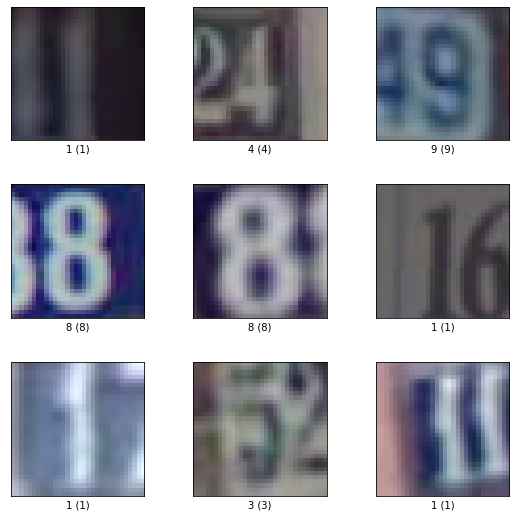

In [5]:
# view 10 samples (color)
fig = tfds.show_examples(train_ds.shuffle(10000).take(10), info)

##### Preprocessing Step

In [11]:
# scale image values and convert to grayscale
# note: grayscale being used per project instructions

def convert_to_grayscale_normalized(image, label, normalize=True):
    grayscale_image= tf.math.reduce_mean(image, axis=-1, keepdims=True)
    return tf.cast(grayscale_image, tf.float32) / 255.0, label

def prep_data(dataset, shuffle=True):
    dataset = dataset.map(convert_to_grayscale_normalized)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# See https://www.tensorflow.org/datasets/keras_example

In [7]:
# Apply preprocessing to test / train / validation sets
train_ds_prepared = prep_data(train_ds, shuffle=True)
validation_ds_prepared = prep_data(validation_ds, shuffle=True)
test_ds_prepared = prep_data(test_ds, shuffle=False)

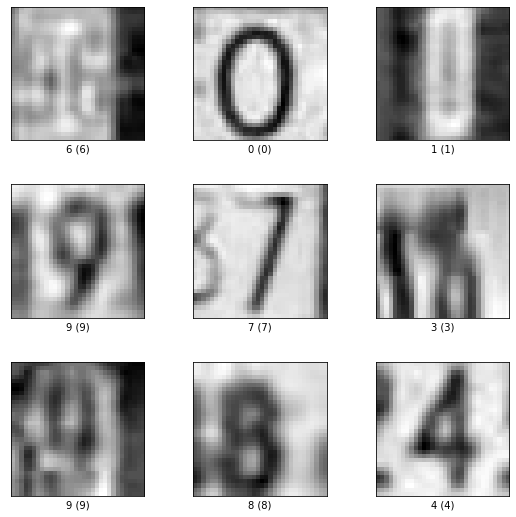

In [15]:
# view 10 samples (grayscale)
def convert_gs(image, label):
    return convert_to_grayscale_normalized(image, label, normalize=False)
    
gs_ds = train_ds.map(convert_gs)

fig = tfds.show_examples(gs_ds.shuffle(10000).take(10), info)

## MLP and CNN Models

##### MLP Model Definition

In [20]:
# Multilayer Perceptron Model
def create_MLP_model(show_summary=True):

    from tensorflow.keras import Sequential 
    from tensorflow.keras.layers import Input, Dense, Flatten

    model = Sequential([
                Input(shape=(32, 32, 1)),
                Flatten(),
                Dense(units=100, activation='relu'),
                Dense(units=100, activation='relu'),
                Dense(units=100, activation='relu'),
                Dense(units=10, activation='softmax'),  # output: 10 class labels
            ])

    if show_summary:
        model.summary()

    return model


##### CNN Model Definition

In [93]:
# Convolutional Neural Network Model
def create_CNN_model(show_summary=True):

    from tensorflow.keras import Sequential 
    from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
    from tensorflow.keras.layers import MaxPool2D, BatchNormalization, Dropout

    model = Sequential([
                Input(shape=(32, 32, 1)),
                Conv2D(filters=32, kernel_size=3, #strides=2,
                       padding='valid', activation='relu'),
                MaxPool2D(padding='same', strides=2),
                BatchNormalization(),
                Dropout(rate=.25),
                Conv2D(filters=32, kernel_size=3, #strides=2,
                       padding='valid', activation='relu'),
                MaxPool2D(padding='same', strides=2),
                BatchNormalization(),
                Dropout(rate=.25),
                Conv2D(filters=64, kernel_size=3, #strides=2,
                       padding='valid', activation='relu'),
                MaxPool2D(padding='same', strides=2),
                Flatten(),
                BatchNormalization(),
                Dense(units=50, activation='relu'),
                Dense(units=10, activation='softmax'),
            ])

    if show_summary:
        model.summary()

    # citation: placing Dropout layers before Conv2D layers
    # (as opposed to after) based on ideas from preprint
    # {Effective and Efficient Dropout for Deep Convolutional Neural Networks}.
    # see bottom of document for BibTex citation info

    return model

##### Define Compile / Fit Framework

In [87]:
# Model production functions
def compile_model(model):

    from tensorflow.keras.metrics \
        import CategoricalCrossentropy, SparseTopKCategoricalAccuracy
    from tensorflow.keras.losses import SparseCategoricalCrossentropy

    model.compile(optimizer='rmsprop', loss=SparseCategoricalCrossentropy(),
                metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3)],
                )

    return None


def fit_model(model, train_ds, valid_ds, num_epochs, save_file_name):

    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    
    filepath = '/content/gdrive/MyDrive/Colab Notebooks/saved_models'
    checkpoint = ModelCheckpoint(filepath=filepath + '/' + save_file_name,
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 mode='max',
                                 save_best_only=True,
                )

    early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=.001, 
                                   patience=5, verbose=0,
                                   )

    history = model.fit(train_ds,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=valid_ds,
                        callbacks=[checkpoint, early_stopping],
                        )

    return history

##### Training: MLP Model

In [95]:
# train MLP Model
MLP_model = create_MLP_model(show_summary=True)
compile_model(MLP_model)
mlp_history = fit_model(MLP_model, train_ds_prepared, validation_ds_prepared,
                    num_epochs=30, save_file_name='capstone_model_MLP')

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               102500    
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1010      
Total params: 123,710
Trainable params: 123,710
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1145/1145 [==============================] - 14s 12ms/step - loss: 2.1923 - accuracy: 0.2031 - sparse_

##### Training: CNN Model

In [94]:
# train CNN Model
CNN_model = create_CNN_model(show_summary=True)
compile_model(CNN_model)
cnn_history = fit_model(CNN_model, train_ds_prepared, validation_ds_prepared,
                    num_epochs=30, save_file_name='capstone_model_CNN')

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 15, 32)        128       
_________________________________________________________________
dropout_27 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 7, 7, 32)        

## Evaluate Performance

##### Overview

The CNN achieves substantially better results (91.17%) on the test set than MLP (61.02%)

In [97]:
# MLP Model Accuracy
MLP_model.evaluate(test_ds_prepared)

204/204 [==============================] - 2s 10ms/step - loss: 1.3165 - accuracy: 0.6102 - sparse_top_k_categorical_accuracy: 0.8152


[1.3165003061294556, 0.6102489233016968, 0.8152273893356323]

In [98]:
# CNN Model Accuracy
CNN_model.evaluate(test_ds_prepared)

204/204 [==============================] - 2s 11ms/step - loss: 0.3464 - accuracy: 0.9117 - sparse_top_k_categorical_accuracy: 0.9753


[0.346358984708786, 0.9117240309715271, 0.9752612113952637]

##### MLP Training Progress

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b51efc50>,
      dtype=object)

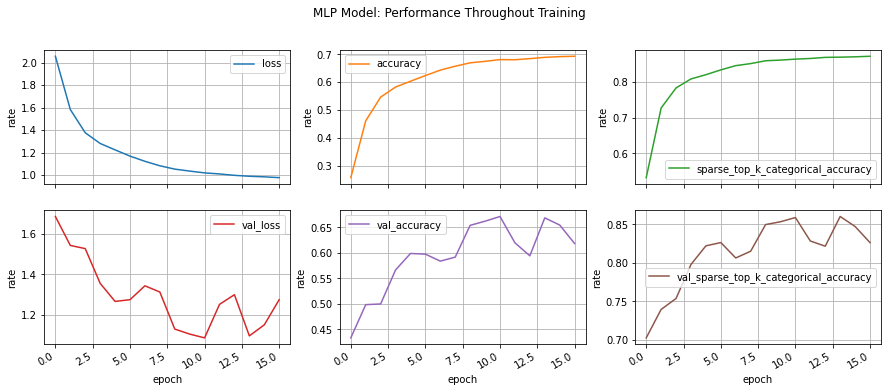

In [99]:
pd.DataFrame(mlp_history.history).plot(
    title='MLP Model: Performance Throughout Training',
    xlabel='epoch',
    ylabel='rate',
    subplots=True,
    sharex=True,
    grid=True,
    layout=(2, 3),
    figsize=(15,6)
)

##### CNN Training Performance

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc3b20090b8>,
      dtype=object)

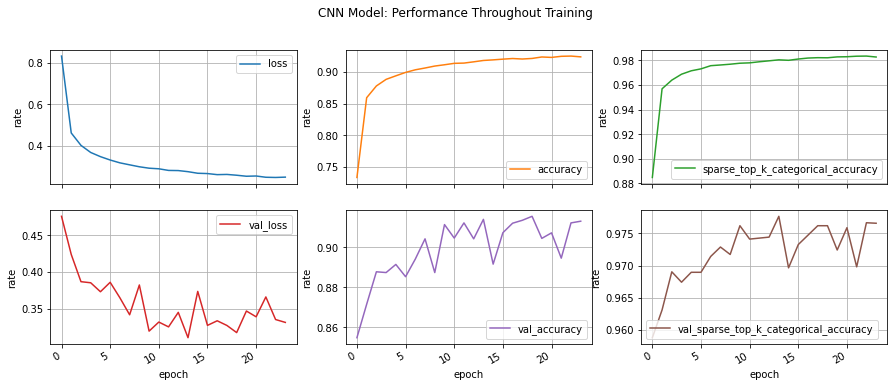

In [100]:
pd.DataFrame(cnn_history.history).plot(
    title='CNN Model: Performance Throughout Training',
    xlabel='epoch',
    ylabel='rate',
    subplots=True,
    sharex=True,
    grid=True,
    layout=(2, 3),
    figsize=(15,6)
)

## Examine model predictions
View predictions from several samples

##### Load model (if needed)

In [101]:
# (If needed:) Reinitialize model and load saved weights
CNN_model = create_CNN_model(show_summary=False)
compile_model(CNN_model)
MLP_model = create_MLP_model(show_summary=False)
compile_model(MLP_model)

filepath = '/content/gdrive/MyDrive/Colab Notebooks/saved_models'
CNN_model.load_weights(filepath + '/capstone_model_CNN')
MLP_model.load_weights(filepath + '/capstone_model_MLP')

##### Select data points

In [102]:
# Examine predictions from a small subsample:
# get 5 samples
small_test_sample = test_ds.take(5)
small_test_sample_prepared = prep_data(small_test_sample, shuffle=False)

# make model predictions
MLP_predictions = pd.DataFrame(MLP_model.predict(small_test_sample_prepared))
CNN_predictions = pd.DataFrame(CNN_model.predict(small_test_sample_prepared))

In [103]:
# unpack images for display
i = -1
sample_images = dict()
for image, info in small_test_sample:
    i+=1
    sample_images[f'image {i}'] = PIL.Image.fromarray(image.numpy()[:,:,0])
    sample_images[f'info {i}'] = info

In [104]:
# helper function for comparing MLP and CNN predictions to actual value
def compare_predictions(image_num, mlp, cnn):

    # display image
    display(sample_images[f'image {image_num}'])

    # create dummy data to show actual value
    correct = np.zeros(10)
    correct[sample_images[f'info {image_num}'].numpy()] = np.log(2)

    # create dataframe with CNN, MLP and actual values
    temp_df = pd.DataFrame({'CNN': np.log(1+cnn.iloc[image_num]),
                            'MLP': np.log(1+mlp.iloc[image_num]),
                            'Actual': correct})
    
    # create bar plot
    ax = temp_df.plot.bar()
    ax.set_title("Model Comparisons")
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Probability (1 + log x)')
    plt.plot

    return ax

##### Show prediction comparisons for each of the 5 samples

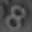

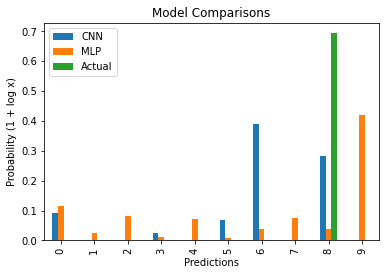

In [105]:
compare_predictions(image_num=0, mlp=MLP_predictions, cnn=CNN_predictions)

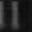

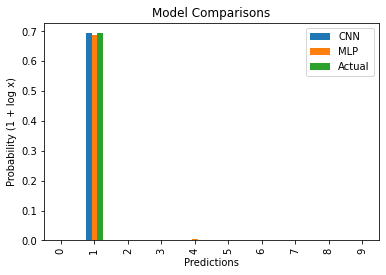

In [106]:
compare_predictions(image_num=1, mlp=MLP_predictions, cnn=CNN_predictions)

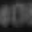

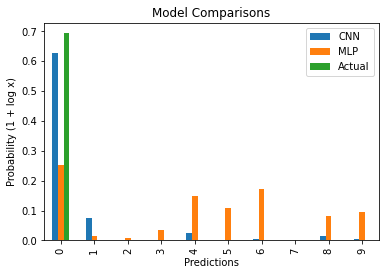

In [107]:
compare_predictions(image_num=2, mlp=MLP_predictions, cnn=CNN_predictions)

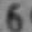

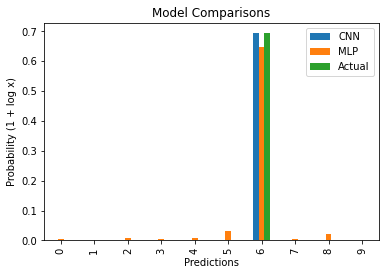

In [108]:
compare_predictions(image_num=3, mlp=MLP_predictions, cnn=CNN_predictions)

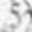

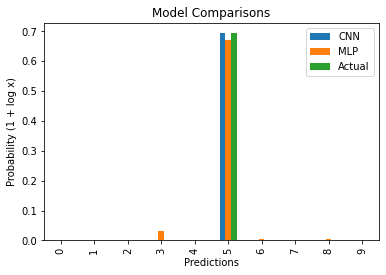

In [109]:
compare_predictions(image_num=4, mlp=MLP_predictions, cnn=CNN_predictions)

#### Works Cited

In [110]:
# Dataset Created by:

# @article{Netzer2011,
# author = {Netzer, Yuval and Wang, Tao and Coates, Adam and Bissacco, Alessandro and Wu, Bo and Ng, Andrew Y},
# booktitle = {Advances in Neural Information Processing Systems ({NIPS})},
# title = {Reading Digits in Natural Images with Unsupervised Feature Learning},
# year = {2011}
# }

In [111]:
# Ideas for CNN Architecture influenced by:

# @article{DBLP:journals/corr/abs-1904-03392,
#  author    = {Shaofeng Cai and
#               Jinyang Gao and
#               Meihui Zhang and
#               Wei Wang and
#               Gang Chen and
#               Beng Chin Ooi},
#  title     = {Effective and Efficient Dropout for Deep Convolutional Neural Networks},
#  journal   = {CoRR},
#  volume    = {abs/1904.03392},
#  year      = {2019},
#  url       = {http://arxiv.org/abs/1904.03392},
#  archivePrefix = {arXiv},
#  eprint    = {1904.03392},
#  timestamp = {Mon, 09 Dec 2019 15:43:45 +0100},
#  biburl    = {https://dblp.org/rec/journals/corr/abs-1904-03392.bib},
#  bibsource = {dblp computer science bibliography, https://dblp.org}
#}